# Прогнозирование ВВП Ганы

#### Мини-проект модуля MATH&ML-13: временные ряды

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima
from arch import arch_model
from sklearn.linear_model import LinearRegression
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv('data/ghana_gdp.csv', index_col='year', parse_dates=['year'])
data = data.asfreq(freq='YS')
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [3]:
#проверяем пропущенные значения
display(data.isna().sum())
#проверяем нулевые значения
display(data[data['GDP (current US$)'] == 0])
data.replace(0, np.NaN, inplace=True)
data.interpolate(inplace=True)

GDP (current US$)    0
dtype: int64

,GDP (current US$)
year,
1961-01-01,0.0


In [4]:
df = data.copy()

---

## 1. Статистические модели прогнозирования

#### Скользящее среднее

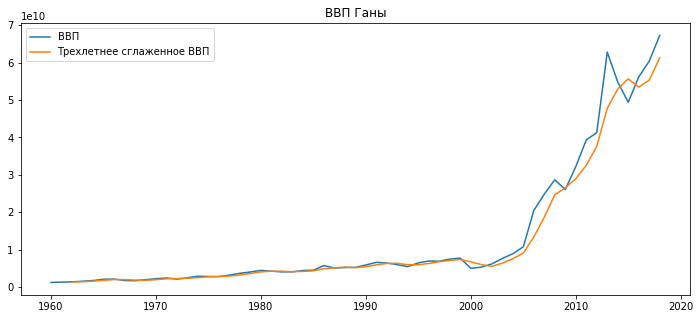

In [5]:
# Train / test data
train, test  = df[:-3].copy(), df[-3:].copy()

# Moving average
ma = train.rolling(3).mean()

plt.figure(figsize=(12, 5))
plt.plot(train, label='ВВП')
plt.plot(ma, label='Трехлетнее сглаженное ВВП')
plt.title('ВВП Ганы')
plt.legend();

#### Сезонность (отсутствует)

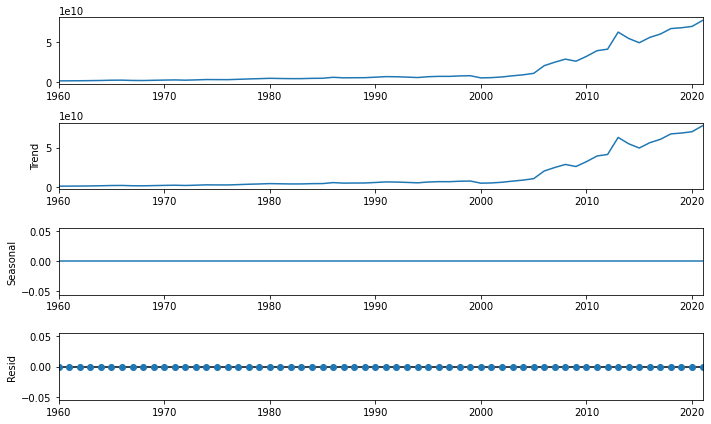

In [6]:
decomposition = seasonal_decompose(df) 
fig = decomposition.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()

#### Тест на стационарность

In [7]:
# Augmented Dickey-Fuller unit root test
aftest = adfuller(train)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

# Test for first differences
diff1 = train.diff()[1:]
aftest = adfuller(diff1)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

# Test for second differences
diff2 = diff1.diff()[1:]
aftest = adfuller(diff2)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

# Test for third differences
diff3 = diff2.diff()[1:]
aftest = adfuller(diff3)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}')

Statistics: 0.8030073326980129
p_value: 0.9916845572455877
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

Statistics: -1.8255652246435998
p_value: 0.36784515276563423
Critical values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}

Statistics: -2.634634746007842
p_value: 0.0860481372219768
Critical values: {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}

Statistics: -4.825603687304014
p_value: 4.857318076800112e-05
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


*Временной ряд нестационарен: интегрированный ряд третьего порядка. Применяем прогноз ARIMA: авторегрессия со скользящим средним для нестационарного ряда, сезонность отсутствует.*

#### Прогноз ARIMA

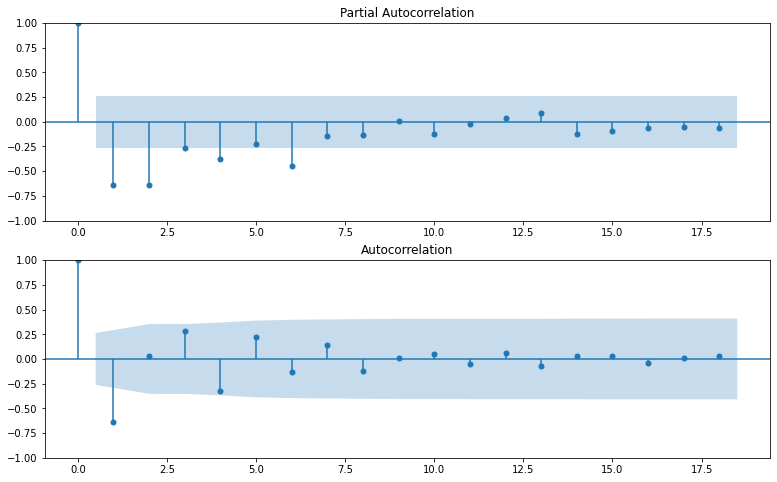

In [8]:
# Выбор параметров
fig, ax = plt.subplots(2, 1, figsize=(13,8))
tsaplots.plot_pacf(diff3, method='ywm', ax=ax[0])
tsaplots.plot_acf(diff3, ax=ax[1])
plt.show()

*Параметры ARIMA: p = 2 (частичная автокорреляция), d = 3 (интегрированный ряд третьего порядка), q = 1 (автокорреляция)* 

In [9]:
# Model
model = ARIMA(train, order=(2, 3, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Mon, 23 Oct 2023   AIC                           2659.226
Time:                        19:11:44   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+57. Standard errors may be unstable.
"""

#### Произведем подбор лучших параметров с  pmdarima. 

* *Параметр p: в районе от 1 до 6*
* *Параметр q: в районе от 1 до 3*
* *Без изменения оставляем нестационарынй ряд третьего порядка: d=3, stationarity=False*
* *Сезонность отсутствует: seasonal=False*

In [10]:
opt_params = pmdarima.auto_arima(
    train,
    start_p=1, start_q=1,
    max_p=6, max_q=3,
    d=3, stationarity=False, seasonal=False,
    trace=True
)    
opt_params.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.03 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.02 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.05 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.02 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.03 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.485 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Mon, 23 Oct 2023   AIC                           2659.226
Time:                        19:11:44   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+57. Standard errors may be unstable.
"""

Параметры остались прежними

In [11]:
# Прогнозирование
df['preds'] = model_fit.predict(start=test.index[0], end=test.index[-1])

# Доверительный интервал
forecast = model_fit.get_forecast(test.shape[0])
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%
df.at[test.index, 'preds_lower'] = forecast_df['lower GDP (current US$)']
df.at[test.index, 'preds_upper'] = forecast_df['upper GDP (current US$)']

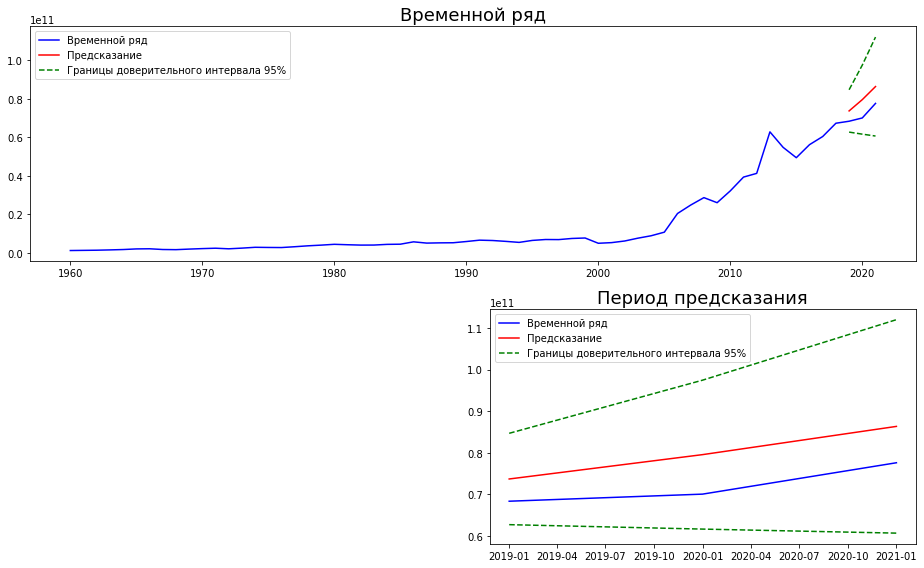

In [12]:
# Предстваление на графике
plt.figure(figsize=(13, 8))

plt.subplot(2, 1, 1)
plt.plot(df['GDP (current US$)'], color='blue', 
         label='Временной ряд')
plt.plot(df.loc[test.index]['preds'], color='red', 
         linestyle='-', label='Предсказание')
plt.plot(df.loc[test.index]['preds_lower'], color='green', 
         linestyle='--', label='Границы доверительного интервала 95%')
plt.plot(df.loc[test.index]['preds_upper'], color='green', 
         linestyle='--')
plt.title('Временной ряд', size=18)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(df.loc[test.index]['GDP (current US$)'], color='blue', 
         label='Временной ряд')
plt.plot(df.loc[test.index]['preds'], color='red', linestyle='-', 
         label='Предсказание')
plt.plot(df.loc[test.index]['preds_lower'], color='green', 
         linestyle='--', label='Границы доверительного интервала 95%')
plt.plot(df.loc[test.index]['preds_upper'], color='green', 
         linestyle='--')
plt.title('Период предсказания', size=18)
plt.legend()

plt.tight_layout()
plt.show()

#### Вывод

*Проведена проверка исходного дата сета на полноту данных. Пропущенное значение ВВП за 1961 год  заменено на линейно-интерполированным значение. Сделан прогноз на крайние три года временного рядя  по модели ARIMA (авторегрессия со скользящим средним для нестационарного ряда). Сезонность временного ряда отсутствует. Как можно заметить прогноз несколько завышен, что можно объяснить тем фактом, что модель ориентировалась на тренд, наблюдающийся с 2014 года. Из положительных моментов можно отметить то, что предсказанный временнной ряд не выходить за 95%-цный доверительный инттервал.*

## 2. Гетероскедастичность

#### Волатильность

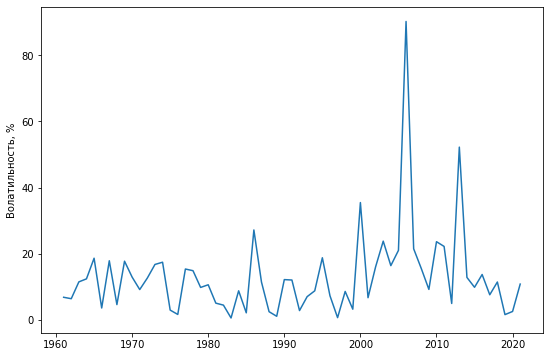

In [13]:
df = data.copy()
vol = (df.pct_change().abs() * 100)[1:]

plt.figure(figsize=(9, 6))
plt.plot(vol)
plt.ylabel('Волатильность, %')
plt.show()

#### Модель GARCH

In [14]:
train, test = vol[:-3], vol[-3:]

# Dickey-Fuller test
adftest = adfuller(train)
print(f'Statistics: {adftest[0]}')
print(f'p_value: {adftest[1]}')
print(f'Critical values: {adftest[4]}')

Statistics: -6.725311059553779
p_value: 3.4014596148856493e-09
Critical values: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}


Можно сделать заключение, что ряд стационарен

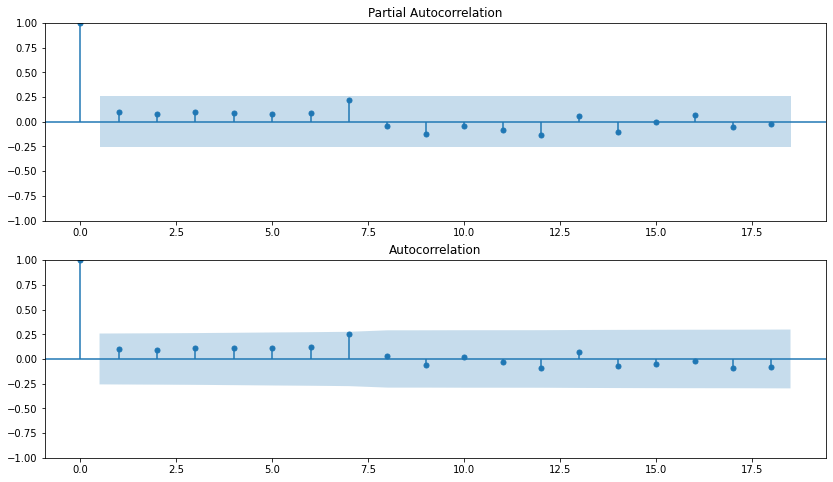

In [15]:
# осуществляем подбор параметров
fig, ax = plt.subplots(2, 1, figsize=(14,8))
tsaplots.plot_pacf(train, method='ywm', ax=ax[0])
tsaplots.plot_acf(train, ax=ax[1])
plt.show()

*Автокорреляция отсутствует, выбираем параметры GARCH: p = 1, q = 1*

In [16]:
model = arch_model(vol, vol='GARCH', p=1, q=1)
model_results = model.fit(last_obs=train.index[-1], update_freq=5)

garch_pred = model_results.forecast(reindex=False).variance.loc[test.index]

Iteration:      5,   Func. Count:     27,   Neg. LLF: 247.95420470455127
Iteration:     10,   Func. Count:     57,   Neg. LLF: 237.6112987195586
Iteration:     15,   Func. Count:     85,   Neg. LLF: 223.50475325756761
Iteration:     20,   Func. Count:    110,   Neg. LLF: 222.86320785503517
Optimization terminated successfully    (Exit mode 0)
            Current function value: 222.86320785503517
            Iterations: 20
            Function evaluations: 110
            Gradient evaluations: 20


#### Линейная регрессия

In [17]:
X_train = np.array(range(train.shape[0])).reshape(-1, 1)
y_train = train.values[:, 0]
X_test = np.array(range(
    train.shape[0], train.shape[0] + test.shape[0])).reshape(-1, 1)
y_test = test.values[:, 0]

reg = LinearRegression()
reg.fit(X_train, y_train)
reg_pred = reg.predict(X_test)
reg_pred = pd.Series(reg_pred, index=test.index)

#### Сравнение результатов двух моделей

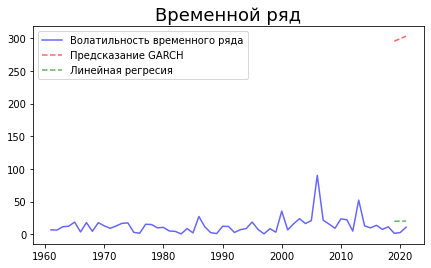

In [18]:
plt.figure(figsize=(7, 4))
plt.plot(vol, color='blue', label='Волатильность временного ряда', alpha=0.6)
plt.plot(garch_pred, color='red', linestyle='--', 
         label='Предсказание GARCH', alpha=0.6)
plt.plot(reg_pred, color='green', linestyle='--', 
         label='Линейная регресия', alpha=0.6)
plt.title('Временной ряд', size=18)
plt.legend()
plt.show()

#### Вывод

*Модель GARCH показывает значительное расхождение с фактическими значениями волатильности. Из автокорреляционных функций видно, что автокорреляция для волатильности в представленном ряде отсутствует, т.е., вообще говоря, модель GARCH в данном случае неприменима, т.к. предыдущие значения ряда не влияют/слабо влияют на последующие. Возможно, что такая зависимость смогла бы проявиться, если бы ряд был более длинным. Простая линейная регрессия показала в данном случае более правдоподобный прогноз.*